In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import heapq
import time
import random
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn import preprocessing
from sklearn import linear_model
from scipy.stats import rankdata
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib import rc
import scipy.stats

from scipy.integrate import trapz

# MC Dropout

In [2]:
skip_training = False  # Set this flag to True before validation and submission

## Data

In [3]:
def data_generating(traindf, testdf):
    # training set
    trainx = traindf.drop('median_house_value', axis=1).values
    trainy = traindf['median_house_value'].values
    # test set
    testx = testdf.drop('median_house_value', axis=1).values
    testy = testdf['median_house_value'].values
   
    scalerx = preprocessing.MinMaxScaler().fit(trainx)
    trainx = scalerx.transform(trainx) + 0.5
    testx = scalerx.transform(testx) + 0.5

    scalery = preprocessing.MinMaxScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1)
    testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)
      
    
    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float)
    y = torch.tensor(trainy[0], dtype = torch.float)
    x_test = torch.tensor(testx, dtype = torch.float)
    y_test = torch.tensor(testy[0], dtype = torch.float)
    
    return x, y, x_test, y_test

## Define Model

In [4]:
class MCDropout(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        super(MCDropout,self).__init__()
        self.net = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Dropout(0,2),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(100,20),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(20, 1))
        
    def forward(self, x):
        # YOUR CODE HERE
        return self.net(x)

## Training Model

In [5]:
def training_MC(mlp, x, y, x_test, y_test, learning_rate = 0.0001, batch_size = 50, num_epoch=1000, tolerance=0.002, patience = 20):
    
    parameters = set(mlp.parameters())
    optimizer = optim.Adam(parameters, lr = learning_rate)
    early_stop = EarlyStopping(tolerance, patience)
    criterion = nn.MSELoss()

    train_errors = []
    val_errors = []

    num_data, num_dim = x.shape
    y = y.view(-1, 1)
    data = torch.cat((x, y), 1)
        
    for epoch in range(num_epoch):
        # permuate the data
        if skip_training :
            break
        data_perm = data[torch.randperm(len(data))]
        x = data_perm[:, 0:-1]
        y = data_perm[:, -1]

        for index in range(int(num_data/batch_size)):
            # data comes in
            inputs = x[index*batch_size : (index+1)*batch_size]
            labels = y[index*batch_size : (index+1)*batch_size].view(-1,1)
            #print(inputs)
            # initialize the gradient of optimizer
            optimizer.zero_grad()
            mlp.train()
            # calculate the loss function

            outputs = mlp(inputs)          
            loss = criterion(outputs, labels)

            # backpropogate the gradient     
            loss.backward()
            # optimize with SGD
            optimizer.step()

        # train and validation loss
        mlp.eval()
        train_errors.append(criterion(mlp.forward(x), y.view(-1,1)))
        val_errors.append(criterion(mlp.forward(x_test), y_test.view(-1,1)))

#         # determine if early stop
#         if early_stop.stop_criterion(val_errors):
#             print(val_errors[epoch])
#             print('Stop after %d epochs' % epoch)
#             break

        if (epoch % 10) == 0:
            print('EPOACH %d: TRAIN LOSS: %.4f; VAL LOSS IS: %.5f.'% (epoch+1, train_errors[epoch], val_errors[epoch]))
        #save the model
        torch.save(mlp.state_dict(), 'MC_mlp_01.pth')
        

In [6]:
# class EarlyStopping:
#     def __init__(self, tolerance, patience):
        
#         self.tolerance = tolerance
#         self.patience = patience
    
#     def stop_criterion(self, val_errors):
#         if len(val_errors) < self.patience + 1:
#             return False
#         else:
#             current_best = min(val_errors[:-self.patience])
#             current_stop = True
#             for i in range(self.patience):
#                 current_stop = current_stop and (val_errors[-i-1] - current_best > self.tolerance)
#             return current_stop

In [7]:
# load the data
# remove none value
df = pd.read_csv("housing.csv", sep = ",")
df = df.dropna(axis = 0)
# remove ocean_proximity
df = df.drop('ocean_proximity', axis = 1)
# split data into training and test set

np.random.seed(129)
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
testdf = df[~msk]
x, y, x_test, y_test = data_generating(traindf, testdf)
num_data, num_feature = x.shape

In [8]:
# set training parameters
l = 1e-4
wr = l**2. / num_data
dr = 2. / num_data
learning_rate = 0.001
batch_size = 50
num_epoch = 1000
tolerance=0.002
patience = 20

In [9]:
mlp = MCDropout()

# training model
mlp.train()
training_MC(mlp, x, y, x_test, y_test, learning_rate, batch_size, num_epoch, tolerance, patience)

if skip_training:
    mlp.load_state_dict(torch.load('MC_mlp_01.pth'))

EPOACH 1: TRAIN LOSS: 0.0269; VAL LOSS IS: 0.02715.
EPOACH 11: TRAIN LOSS: 0.0207; VAL LOSS IS: 0.02131.
EPOACH 21: TRAIN LOSS: 0.0187; VAL LOSS IS: 0.01938.
EPOACH 31: TRAIN LOSS: 0.0261; VAL LOSS IS: 0.02681.
EPOACH 41: TRAIN LOSS: 0.0191; VAL LOSS IS: 0.01992.
EPOACH 51: TRAIN LOSS: 0.0230; VAL LOSS IS: 0.02371.
EPOACH 61: TRAIN LOSS: 0.0271; VAL LOSS IS: 0.02782.
EPOACH 71: TRAIN LOSS: 0.0252; VAL LOSS IS: 0.02599.
EPOACH 81: TRAIN LOSS: 0.0181; VAL LOSS IS: 0.01893.
EPOACH 91: TRAIN LOSS: 0.0261; VAL LOSS IS: 0.02680.
tensor(0.0306, grad_fn=<MseLossBackward>)
Stop after 94 epochs


## MC Sample 

In [11]:
# MC sample 
K_test = 100 # sample 20 times 
mlp.train() 
MC_samples = [mlp(x_test) for _ in range(K_test)]  
# calculate the means 
mean_samples = torch.stack([tup for tup in MC_samples]).view(K_test, x_test.shape[0]).cpu().data.numpy()   # shape K_test * val_set_size
mean = np.mean(mean_samples, 0)
epistemic_uncertainty = np.std(mean_samples, 0)

## Evaluation

In [13]:
# hit probability
def hit_probability(y_test, mean, epistemic_uncertainty, confidence):
    confidence_lower, confidence_higher = scipy.stats.norm.interval(confidence , mean, epistemic_uncertainty)
    return np.sum([1 if y_test[i] <= confidence_higher[i] and y_test[i] >= confidence_lower[i] else 0 for i in range(len(y_test))]) / len(y_test)

the area between two lines is =  0.19297425309691518


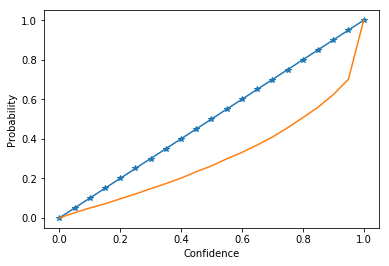

In [14]:
confidence = np.linspace(0, 1.0, 21, endpoint = True)
#print(confidence)
plt.plot(confidence, confidence, '-*')
hit_ratio = [hit_probability(y_test, mean, epistemic_uncertainty, c) for c in confidence]
plt.plot(confidence, hit_ratio)
plt.xlabel("Confidence")
plt.ylabel("Probability")
plt.savefig("mcdropout.eps", format="eps", dpi=1000)
area1 = trapz(confidence, dx = 0.05)
area2 = trapz(hit_ratio, dx = 0.05)
print("the area between two lines is = ", area1 - area2)